In [1]:
%pylab inline
import pandas as pd
import seaborn as sns

genes = pd.read_csv('gene_expression_s.csv', index_col=0).sort_index(0).sort_index(1)
sample_data = pd.read_csv('sample_info_qc_pt.csv', index_col=0).sort_index(0).sort_index(1)

GFP = genes.ix['GFP']

sample_data = sample_data.ix[sample_data["Pass QC"]]
sample_data = sample_data.query('cluster != "x"')

genes = genes[sample_data.index]

ercc_idx = filter(lambda i: 'ERCC' in i, genes.index)
egenes = genes.drop(ercc_idx)
egenes = egenes.drop('GFP')
egenes = (egenes / egenes.sum()) * 1e6

gene_annotation = pd.read_csv('zv9_gene_annotation.txt', sep='\t', index_col=0)
gene_annotation = gene_annotation.ix[egenes.index]

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ast import literal_eval
sample_data['cluster_color'] = sample_data['cluster_color'].apply(literal_eval)

sample_data['ranktime'] = sample_data['pseudotime'].rank()

logexp = np.log10(egenes + 1)

In [3]:
sample_data = sample_data.sort('ranktime')
logexp = logexp[sample_data.index]

In [6]:
gene_id = 'ENSDARG00000013477'  # gata1a

In [7]:
from sklearn.preprocessing import scale

In [8]:
import GPy

/homes/vale/anaconda/lib/python2.7/site-packages/GPy/util/linalg.py:48: UserWarning: warning: caught this exception:/homes/vale/anaconda/lib/python2.7/site-packages/numpy/core/_dotblas.so: undefined symbol: dsyrk_
  warnings.warn("warning: caught this exception:" + str(e))


In [9]:
from scipy import stats

In [11]:
# Sort cells bys pseudotime

ranktime = sample_data.ranktime.copy()
ranktime.sort()
logexp = logexp[ranktime.index]

Split up genes to out-of-core train GPs for every gene in a parallell fashion.

    logexp_splits = np.array_split(logexp, 50)
    for i, logexp_split in enumerate(logexp_splits):
        logexp_split.to_csv('fit_gps/logexp_{:03}.csv'.format(i))

    ranktime.to_csv('fit_gps/x_vals.csv')

In [15]:
from glob import iglob

In [16]:
# Read in results from parallell GP training.
rbf_dfs = []
const_dfs = []
for gp_f in iglob('fit_gps/gp_*.csv'):
    if 'rbf' in gp_f:
        rbf_dfs.append(pd.read_csv(gp_f, index_col=0))
    else:
        const_dfs.append(pd.read_csv(gp_f, index_col=0))
    
rbf_gps = pd.concat(rbf_dfs)
const_gps = pd.concat(const_dfs)

In [17]:
rbf_gps = rbf_gps.sort_index()
const_gps = const_gps.sort_index()

In [18]:
# D-statistic of the different models for each gene
D = -2 * const_gps['log_likelihood'] + 2 * rbf_gps['log_likelihood']

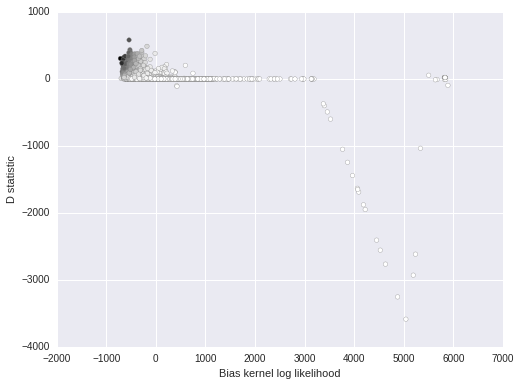

In [19]:
figsize(8, 6)
plt.scatter(const_gps.ix[const_gps.index, 'log_likelihood'],
            D.ix[const_gps.index],
            c=rbf_gps.ix[:, 4:204].std(1),
            edgecolor='grey')

sns.axlabel('Bias kernel log likelihood', 'D statistic')
sns.despine();

In [20]:
sns.set_style('white')

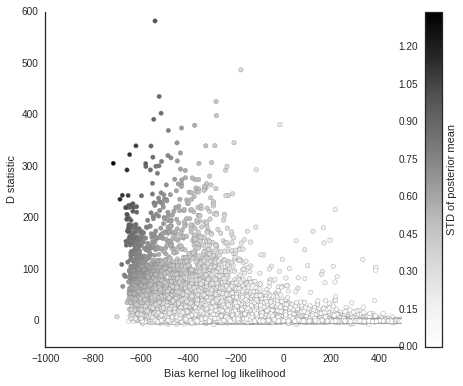

In [21]:
figsize(8, 6)
plt.scatter(const_gps.ix[const_gps.index, 'log_likelihood'],
            D.ix[const_gps.index],
            c=rbf_gps.ix[:, 4:204].std(1),
            edgecolor='grey')

plt.xlim(-1000, 500)
plt.ylim(-50, 600)

plt.colorbar(label='STD of posterior mean');
sns.axlabel('Bias kernel log likelihood', 'D statistic')
sns.despine();

In [23]:
# Collect features of the models in a DataFrame

gp_info = pd.DataFrame({'D': D})

gp_info['stde'] = rbf_gps.ix[:, 4:204].std(1)

xx = np.linspace(0, 361, 200)[:,None]
peaktime = xx[rbf_gps.ix[:, 4:204].as_matrix().argmax(1)]
gp_info['pktm'] = peaktime

130


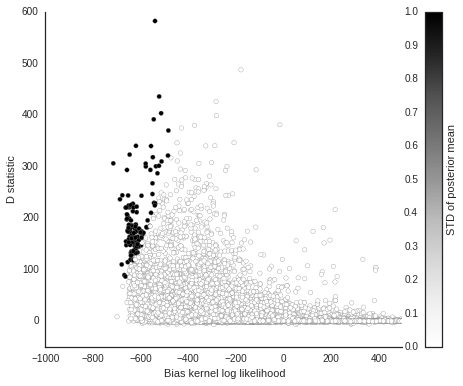

In [117]:
std_threshold = 0.75

figsize(8, 6)
plt.scatter(const_gps.ix[const_gps.index, 'log_likelihood'],
            D.ix[const_gps.index],
            c=gp_info['stde'] > std_threshold,
            edgecolor='grey')

plt.xlim(-1000, 500)
plt.ylim(-50, 600)

plt.colorbar(label='STD of posterior mean');
sns.axlabel('Bias kernel log likelihood', 'D statistic')
sns.despine();

print((gp_info['stde'] > std_threshold).sum())

In [118]:
# Index of significantly varying genes sorted by peak time
idx = gp_info.query('stde > {}'.format(std_threshold)).sort('pktm', ascending=True).index

In [119]:
from sklearn import preprocessing

In [120]:
M = preprocessing.scale(rbf_gps.ix[idx, 4:204], 1)

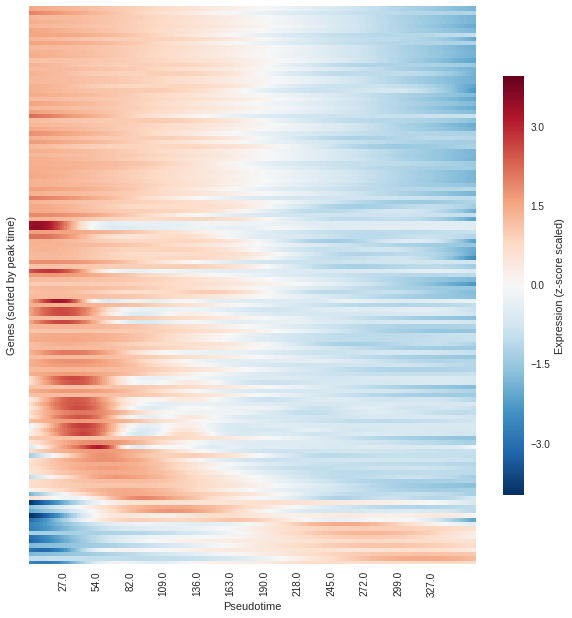

In [121]:
figsize(10, 10)
sns.heatmap(M, lw=0,
            yticklabels=False,
            xticklabels=True,
            cbar_kws={'label': 'Expression (z-score scaled)', 'shrink':.75});

loc, lab = plt.xticks()
plt.xticks(loc[::15][1:-1], np.round(xx[::15, 0])[1:-1])
plt.xlabel('Pseudotime')
plt.ylabel('Genes (sorted by peak time)');

### Cluster genes by underlying functions

In [122]:
sys.path.append('/nfs/research2/teichmann/valentine/GPclust/')

In [123]:
import GPclust

In [124]:
Y_ts = logexp.ix[idx].as_matrix()
X_ts = np.atleast_2d(ranktime).T

In [138]:
k_underlying = GPy.kern.RBF(input_dim=1, variance=0.5, lengthscale=150)
k_corruption = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=50) + GPy.kern.White(input_dim=1, variance=0.01)

m = GPclust.MOHGP(X_ts, k_underlying, k_corruption, Y_ts, K=4, prior_Z='DP', alpha=1.0)

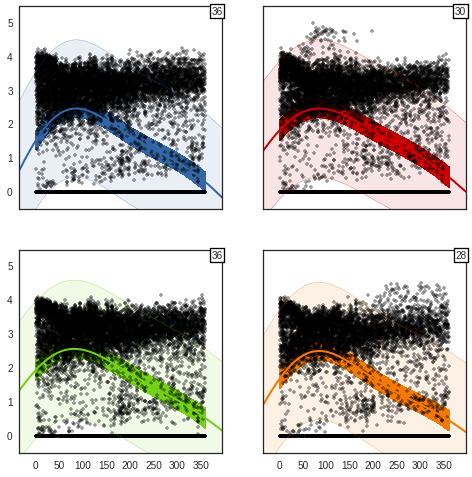

In [139]:
figsize(8, 8)
m.plot(on_subplots=True, colour=True, newfig=False, joined=False, data_in_grey=True, errorbars=True)

In [140]:
m.optimize()

iteration 39 bound=-2286905.68999 grad=2.63450229316e-07, beta=0.0 vb converged (gtol)
iteration 48 bound=-68797.5906814 grad=9.06878631854e-07, beta=0.0792150317149 vb converged (ftol)
vb converged (gtol)
iteration 53 bound=-68640.8907988 grad=6.41470745142e-07, beta=0.105698330234 vb converged (ftol)


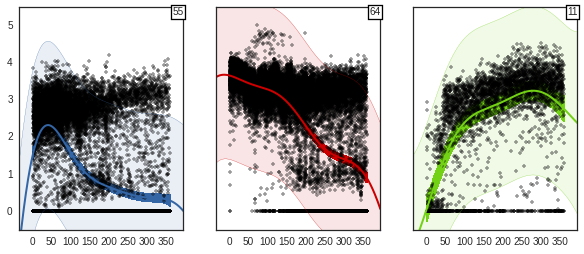

In [141]:
figsize(10, 4)
m.plot(on_subplots=True, colour=True, newfig=False, joined=False, data_in_grey=True, errorbars=True)

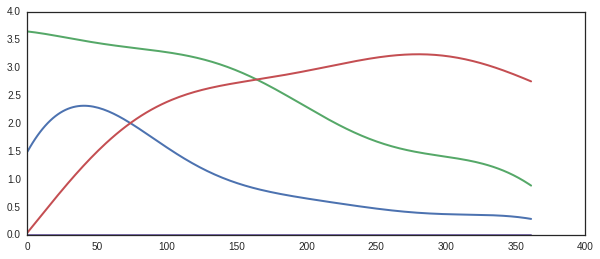

In [142]:
for i in range(4):
    plt.plot(xx, m.predict_components(xx)[0][i], lw=2);

In [143]:
cluster_membership = pd.DataFrame({'cluster': np.argmax(m.phi,1)}, index=idx)

In [144]:
cluster_membership.head()

,cluster
ENSDARG00000036298,1
ENSDARG00000077533,0
ENSDARG00000019230,1
ENSDARG00000019778,1
ENSDARG00000070849,1


In [145]:
cluster_membership.cluster.value_counts()

1    64
0    55
2    11
dtype: int64

In [146]:
from gprofiler import gprofiler

In [251]:
query = list(cluster_membership.query('cluster == 0').index)
result = gprofiler(query, organism='drerio')
result.sort('p.value')[['p.value', 'term.name']].to_csv('cluster_I_enrichment.csv')
result.sort('p.value')[['p.value', 'term.name']].head(10)

,p.value,term.name
term.id,,
GO:0003676,0.000098,nucleic acid binding
GO:0005622,0.000138,intracellular
GO:0044424,0.000141,intracellular part
REAC:6272927,0.000282,Chromosome Maintenance
REAC:6272642,0.000517,mRNA Splicing - Minor Pathway
REAC:6273028,0.001930,Removal of the Flap Intermediate from ...
REAC:6273026,0.003520,Processive synthesis on the C-strand of...
GO:0008135,0.003920,"translation factor activity, RNA binding"
REAC:6272431,0.005640,Mitotic G1-G1/S phases


In [252]:
query = list(cluster_membership.query('cluster == 1').index)
result = gprofiler(query, organism='drerio')
result.sort('p.value')[['p.value', 'term.name']].to_csv('cluster_II_enrichment.csv')
result.sort('p.value')[['p.value', 'term.name']].head(10)

,p.value,term.name
term.id,,
REAC:6272884,2.940000e-105,Eukaryotic Translation Elongation
REAC:6272883,7.880000e-100,Peptide chain elongation
REAC:6272876,4.630000e-99,Eukaryotic Translation Termination
GO:0005840,1.150000e-96,ribosome
REAC:6273493,3.080000e-96,Nonsense Mediated Decay (NMD) independent...
REAC:6272541,4.870000e-94,Formation of a pool of free 40S subunits
REAC:6273624,2.560000e-92,SRP-dependent cotranslational protein tar...
GO:0003735,4.210000e-92,structural constituent of ribosome
REAC:6273495,3.060000e-91,Nonsense Mediated Decay (NMD) enhanced by...


In [253]:
query = list(cluster_membership.query('cluster == 2').index)
result = gprofiler(query, organism='drerio')
result.sort('p.value')[['p.value', 'term.name']].to_csv('cluster_III_enrichment.csv')
result.sort('p.value')[['p.value', 'term.name']].head(10)

,p.value,term.name
term.id,,
KEGG:04512,0.000168,ECM-receptor interaction
REAC:6273229,0.000176,Platelet Aggregation (Plug Formation)
GO:0072359,0.000617,circulatory system development
GO:0072358,0.000617,cardiovascular system development
REAC:6272840,0.000639,"Platelet activation, signaling and aggrega..."
REAC:6272843,0.000888,Integrin cell surface interactions
REAC:6273220,0.004000,Platelet degranulation
REAC:6272842,0.004800,Response to elevated platelet cytosolic Ca2+
REAC:6273234,0.006830,p130Cas linkage to MAPK signaling for i...


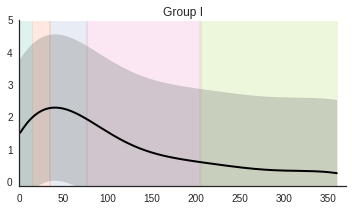

In [217]:
figsize(5, 3)

cluster = 0

fixed_inputs = []
fixed_dims = np.array([i for i,v in fixed_inputs])
free_dims = np.setdiff1d(np.arange(m.X.shape[1]),fixed_dims)

col='k'

X = m.X[:,free_dims]
xmin, xmax = X.min(), X.max()

Xgrid = np.empty((300, m.X.shape[1]))
Xgrid[:,free_dims] = np.linspace(xmin,xmax,300)[:,None]
for i,v in fixed_inputs:
    Xgrid[:,i] = v
    
mu  = m.predict_components(Xgrid)[0][cluster]
var = m.predict_components(Xgrid)[1][cluster]

cluster_intervals = zip(sample_data.groupby('cluster').first()['ranktime'] - 1,
                        sample_data.groupby('cluster').last()['ranktime'] + 1)
cluster_intervals_color = sample_data.groupby('cluster').first()['cluster_color']

for interval, colr in zip(cluster_intervals, cluster_intervals_color):
    plt.axvspan(*interval, facecolor=colr, zorder=-1, edgecolor='none', alpha=0.2)


plt.fill_between(Xgrid[:,free_dims].flatten(),
                 mu - 2. * np.sqrt(np.diag(var)),
                 mu + 2. * np.sqrt(np.diag(var)),
                 alpha=0.33,
                 color='grey',
                 zorder=1,)

plt.plot(Xgrid[:,free_dims].flatten(), mu.flatten(), lw=2, zorder=2, color='k')

plt.ylim(-0.1, 5)
plt.xlim(0, 370)

sns.despine()
plt.title('Group I')

plt.tight_layout();
plt.savefig('figures/pseudotime_cluster_I.pdf')

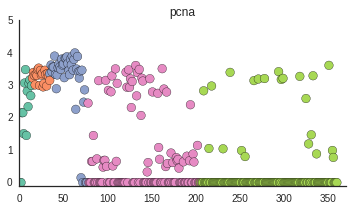

In [216]:
figsize(5, 3)
g = 'ENSDARG00000054155'

plt.scatter(sample_data.ranktime, logexp.ix[g], color=sample_data.cluster_color, edgecolor='k', s=75);
plt.title(gene_annotation.ix[g, 'Associated Gene Name'])

plt.ylim(-0.1, 5);
plt.xlim(0, 370)
sns.despine();

plt.tight_layout();
plt.savefig('figures/pseudotime_cluster_I_example.pdf')

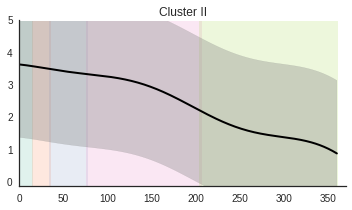

In [218]:
figsize(5, 3)

cluster = 1

fixed_inputs = []
fixed_dims = np.array([i for i,v in fixed_inputs])
free_dims = np.setdiff1d(np.arange(m.X.shape[1]),fixed_dims)

col='k'

X = m.X[:,free_dims]
xmin, xmax = X.min(), X.max()

Xgrid = np.empty((300, m.X.shape[1]))
Xgrid[:,free_dims] = np.linspace(xmin,xmax,300)[:,None]
for i,v in fixed_inputs:
    Xgrid[:,i] = v
    
mu  = m.predict_components(Xgrid)[0][cluster]
var = m.predict_components(Xgrid)[1][cluster]

cluster_intervals = zip(sample_data.groupby('cluster').first()['ranktime'] - 1,
                        sample_data.groupby('cluster').last()['ranktime'] + 1)
cluster_intervals_color = sample_data.groupby('cluster').first()['cluster_color']

for interval, colr in zip(cluster_intervals, cluster_intervals_color):
    plt.axvspan(*interval, facecolor=colr, zorder=-1, edgecolor='none', alpha=0.2)


plt.fill_between(Xgrid[:,free_dims].flatten(),
                 mu - 2. * np.sqrt(np.diag(var)),
                 mu + 2. * np.sqrt(np.diag(var)),
                 alpha=0.33,
                 color='grey',
                 zorder=1,)

plt.plot(Xgrid[:,free_dims].flatten(), mu.flatten(), lw=2, zorder=2, color='k')

plt.ylim(-0.1, 5)
plt.xlim(0, 370)

sns.despine()
plt.title('Cluster II')

plt.tight_layout();
plt.savefig('figures/pseudotime_cluster_II.pdf')

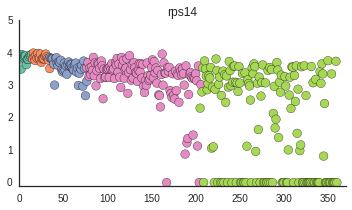

In [219]:
figsize(5, 3)
g = 'ENSDARG00000036629'
plt.scatter(sample_data.ranktime, logexp.ix[g], color=sample_data.cluster_color, edgecolor='k', s=75);
plt.title(gene_annotation.ix[g, 'Associated Gene Name'])

plt.ylim(-0.1, 5);
plt.xlim(0, 370)
sns.despine();

plt.tight_layout();
plt.savefig('figures/pseudotime_cluster_II_example.pdf')

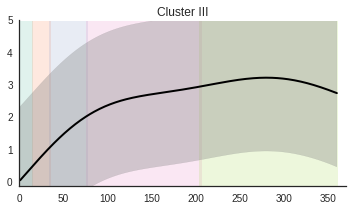

In [220]:
figsize(5, 3)

cluster = 2

fixed_inputs = []
fixed_dims = np.array([i for i,v in fixed_inputs])
free_dims = np.setdiff1d(np.arange(m.X.shape[1]),fixed_dims)

col='k'

X = m.X[:,free_dims]
xmin, xmax = X.min(), X.max()

Xgrid = np.empty((300, m.X.shape[1]))
Xgrid[:,free_dims] = np.linspace(xmin,xmax,300)[:,None]
for i,v in fixed_inputs:
    Xgrid[:,i] = v
    
mu  = m.predict_components(Xgrid)[0][cluster]
var = m.predict_components(Xgrid)[1][cluster]

cluster_intervals = zip(sample_data.groupby('cluster').first()['ranktime'] - 1,
                        sample_data.groupby('cluster').last()['ranktime'] + 1)
cluster_intervals_color = sample_data.groupby('cluster').first()['cluster_color']

for interval, colr in zip(cluster_intervals, cluster_intervals_color):
    plt.axvspan(*interval, facecolor=colr, zorder=-1, edgecolor='none', alpha=0.2)


plt.fill_between(Xgrid[:,free_dims].flatten(),
                 mu - 2. * np.sqrt(np.diag(var)),
                 mu + 2. * np.sqrt(np.diag(var)),
                 alpha=0.33,
                 color='grey',
                 zorder=1,)

plt.plot(Xgrid[:,free_dims].flatten(), mu.flatten(), lw=2, zorder=2, color='k')

plt.ylim(-0.1, 5)
plt.xlim(0, 370)

sns.despine()
plt.title('Cluster III')

plt.tight_layout();
plt.savefig('figures/pseudotime_cluster_III.pdf')

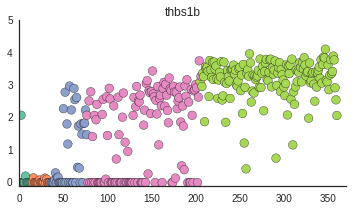

In [221]:
figsize(5, 3)
g = 'ENSDARG00000010785'

plt.scatter(sample_data.ranktime, logexp.ix[g], color=sample_data.cluster_color, edgecolor='k', s=75);
plt.title(gene_annotation.ix[g, 'Associated Gene Name'])

plt.ylim(-0.1, 5);
plt.xlim(0, 370)
sns.despine();

plt.tight_layout();
plt.savefig('figures/pseudotime_cluster_III_example.pdf')

In [240]:
from matplotlib import gridspec

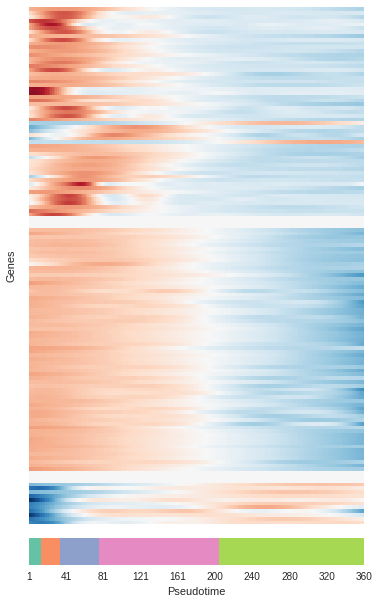

In [249]:
figsize(6, 10)

M = preprocessing.scale(rbf_gps.ix[cluster_membership.sort('cluster').index, 4:204], 1)

breaks = np.where((cluster_membership.sort('cluster').diff() != 0).as_matrix())[0]

shift = 3
Ms = np.zeros((M.shape[0] + shift * (len(breaks) - 1), M.shape[1]))
for i in range(len(breaks) - 1):
    Ms[breaks[i] + shift * i : breaks[i+1] + shift * i] = M[breaks[i]:breaks[i+1]]
    
Ms[breaks[i+1] + shift * (i+1) : ] = M[breaks[i+1]: ]

gs = gridspec.GridSpec(2, 1, hspace=0.05, height_ratios=(0.95, 0.05))

plt.subplot(gs[0, 0])

sns.heatmap(Ms,
            lw=0,
            square=False,
            cbar=False,
            yticklabels=False,
            xticklabels=False,
           );

loc, lab = plt.xticks()
plt.ylabel('Genes');

plt.subplot(gs[1, 0])

for interval, colr in zip(cluster_intervals, cluster_intervals_color):
    plt.axvspan(*interval, facecolor=colr, zorder=-1, edgecolor='none', alpha=1)
    
plt.yticks([])
x_ticks = np.linspace(sample_data.ranktime.min(), sample_data.ranktime.max(), 10)
plt.xlim(x_ticks.min(), x_ticks.max())
plt.xticks(x_ticks, map(int, np.round(x_ticks)))
plt.xlabel('Pseudotime')

sns.despine(left=True, bottom=True)

plt.savefig('figures/pseudotime_clusters_heatmap.pdf');

In [273]:
# Note that the name of the cluster need to be identified manually,
# they change order when you run the clustering algorithm
cluster = 1

mu_2 = m.predict_components(np.atleast_2d(sample_data.ranktime).T)[0][cluster]

mRNA_content = 1e6 - sample_data['ERCC Content']

stats.spearmanr(mRNA_content, mu_2)

(0.8499805618331181, 1.1172628273280196e-101)

In [274]:
cluster_membership.query('cluster == 2').index

Index([u'ENSDARG00000023963', u'ENSDARG00000074441', u'ENSDARG00000019845', u'ENSDARG00000069027', u'ENSDARG00000053279', u'ENSDARG00000077069', u'ENSDARG00000019861', u'ENSDARG00000042934', u'ENSDARG00000006526', u'ENSDARG00000010785', u'ENSDARG00000018687'], dtype='object')

In [283]:
genes = pd.read_csv('gene_expression_s.csv', index_col=0).sort_index(0).sort_index(1)
sample_data = pd.read_csv('sample_info_qc.csv', index_col=0).sort_index(0).sort_index(1)

GFP = genes.ix['GFP']

sample_data = sample_data.ix[sample_data["Pass QC"]]

genes = genes[sample_data.index]

ercc_idx = filter(lambda i: 'ERCC' in i, genes.index)
egenes = genes.drop(ercc_idx)
egenes = egenes.drop('GFP')
egenes = (egenes / egenes.sum()) * 1e6


In [286]:
sample_data.query('cluster == "x"').index

Index([u'HIGH_1_A2', u'HIGH_1_B9', u'HIGH_1_F2'], dtype='object')

In [292]:
y_2m = egenes.ix[cluster_membership.query('cluster == 2').index, sample_data.query('cluster == "x"').index].mean(1)
y_2m

ENSDARG00000023963    115.815591
ENSDARG00000074441     26.356134
ENSDARG00000019845     17.519480
ENSDARG00000069027      0.000000
ENSDARG00000053279    245.493860
ENSDARG00000077069    959.557647
ENSDARG00000019861    707.558095
ENSDARG00000042934    547.579990
ENSDARG00000006526    204.073068
ENSDARG00000010785    205.952666
ENSDARG00000018687    117.470981
dtype: float64

In [293]:
x_2m = egenes.ix[cluster_membership.query('cluster == 2').index, sample_data.query('cluster == "4"').index].mean(1)
x_2m

ENSDARG00000023963     1868.475453
ENSDARG00000074441     1816.426768
ENSDARG00000019845      957.137155
ENSDARG00000069027     1930.177976
ENSDARG00000053279     3838.321464
ENSDARG00000077069     6381.737076
ENSDARG00000019861     2397.867928
ENSDARG00000042934    10504.528027
ENSDARG00000006526     3245.929712
ENSDARG00000010785     2623.087071
ENSDARG00000018687     3169.494899
dtype: float64

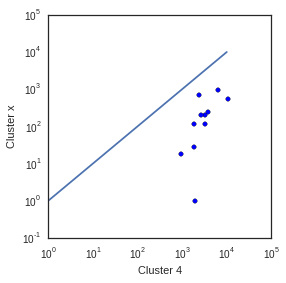

In [301]:
figsize(4, 4)
plt.scatter(x_2m + 1, y_2m + 1);
plt.plot([1, 1e4+1], [1, 1e4+1]);
plt.loglog();
sns.axlabel('Cluster 4', 'Cluster x');

In [309]:
membership_table = pd.DataFrame({'group': cluster_membership.cluster.map(lambda s: 'I' * (s + 1)).sort(inplace=False)})

In [312]:
membership_table['Associated Gene Name'] = gene_annotation.ix[membership_table.index, 'Associated Gene Name']

In [321]:
membership_table \
[['Associated Gene Name', 'group']] \
.sort(['group', 'Associated Gene Name']) \
.to_csv('pseudotime_gene_groups_membership.csv')